In [29]:
# Cargando las librerias a usar

import pandas as pd
import numpy as np
import re, os
from urllib.parse import urlparse
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from urllib.parse import urlparse, parse_qs
from imblearn.under_sampling import RandomUnderSampler
import joblib


In [30]:
#cargar los datos
df1 = pd.read_csv('data_url.csv')
df1

,url,isMalicious
0,songlyrics.com/news/riffd-the-shins-heartworms,0
1,imaging-resource.com/PRODS/olympus-e-m1-ii/oly...,0
2,gosugamers.net/lol/streams,0
3,thingiverse.com/corkyzett/collections/intlwome...,0
4,bausch.com/our-products/contact-lens-care/spec...,0
...,...,...
212830,tomandmatattack.com/0/do.php,1
212831,ebay.com/bhp/1940-s-polka-dot-dress,0
212832,chec.com.pk/_errorpages/po/pop/ce5c873665a2afa...,1
212833,litopia21.com/morningform/file/update/07/index...,1


In [31]:
#informacion inicial
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212835 entries, 0 to 212834
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   url          212835 non-null  object
 1   isMalicious  212835 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


In [32]:
#verificar si hay duplicados

df1.duplicated().sum()

np.int64(25467)

In [33]:
#Eliminar valores duplicados

df1.drop_duplicates(inplace=True)

In [34]:
#verificar si se eliminaron los duplicados

df1.duplicated().sum()

np.int64(0)

In [35]:
#verificar valores nulos

df1.isnull().sum()

,0
url,0
isMalicious,0


In [36]:
#contar registros

df1.count()

,0
url,187368
isMalicious,187368


In [37]:
#Contar cuantos reguistros con 1 en la columna "isMalicious" hay

df1[df1['isMalicious'] == 1].count()

,0
url,80401
isMalicious,80401


In [38]:
#Contar cuantos reguistros con 0 en la columna "isMalicious" hay

df1[df1['isMalicious'] == 0].count()

,0
url,106967
isMalicious,106967


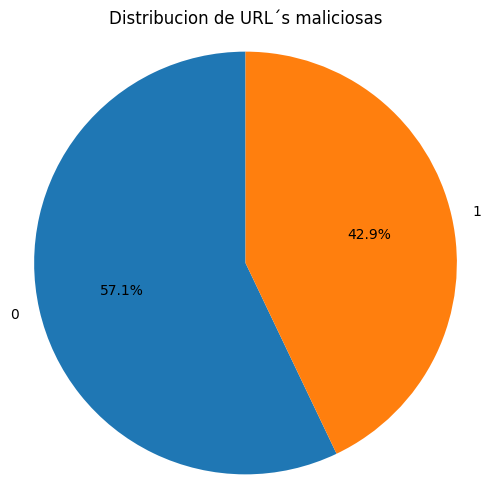

In [39]:
import matplotlib.pyplot as plt

malicious_counts = df1['isMalicious'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(malicious_counts, labels=malicious_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribucion de URL´s maliciosas') #donde 1 es una URL maliciosa y 0 no
plt.axis('equal')
plt.show()


In [40]:
#normalizar URL´s (minusculas y eliminar espacios)

df1['url'] = df1['url'].str.lower()
df1['url'] = df1['url'].str.replace(' ', '')
df1

,url,isMalicious
0,songlyrics.com/news/riffd-the-shins-heartworms,0
1,imaging-resource.com/prods/olympus-e-m1-ii/oly...,0
2,gosugamers.net/lol/streams,0
3,thingiverse.com/corkyzett/collections/intlwome...,0
4,bausch.com/our-products/contact-lens-care/spec...,0
...,...,...
212829,amazon.co.uk/0141024488-books-trade-in/s?ie=ut...,0
212830,tomandmatattack.com/0/do.php,1
212831,ebay.com/bhp/1940-s-polka-dot-dress,0
212832,chec.com.pk/_errorpages/po/pop/ce5c873665a2afa...,1


In [41]:
#Identificación de el largo de los URL
df1['url_length'] = df1['url'].str.len()
df1

,url,isMalicious,url_length
0,songlyrics.com/news/riffd-the-shins-heartworms,0,46
1,imaging-resource.com/prods/olympus-e-m1-ii/oly...,0,63
2,gosugamers.net/lol/streams,0,26
3,thingiverse.com/corkyzett/collections/intlwome...,0,51
4,bausch.com/our-products/contact-lens-care/spec...,0,70
...,...,...,...
212829,amazon.co.uk/0141024488-books-trade-in/s?ie=ut...,0,89
212830,tomandmatattack.com/0/do.php,1,28
212831,ebay.com/bhp/1940-s-polka-dot-dress,0,35
212832,chec.com.pk/_errorpages/po/pop/ce5c873665a2afa...,1,73


In [42]:
#Identificación de caracteres especiales en URL

import re

def count_special_chars(url):
  special_chars = re.findall(r'[^\w\s]', url)
  return len(special_chars)

df1['special_chars_count'] = df1['url'].apply(count_special_chars)
df1

,url,isMalicious,url_length,special_chars_count
0,songlyrics.com/news/riffd-the-shins-heartworms,0,46,6
1,imaging-resource.com/prods/olympus-e-m1-ii/oly...,0,63,12
2,gosugamers.net/lol/streams,0,26,3
3,thingiverse.com/corkyzett/collections/intlwome...,0,51,4
4,bausch.com/our-products/contact-lens-care/spec...,0,70,10
...,...,...,...,...
212829,amazon.co.uk/0141024488-books-trade-in/s?ie=ut...,0,89,16
212830,tomandmatattack.com/0/do.php,1,28,4
212831,ebay.com/bhp/1940-s-polka-dot-dress,0,35,7
212832,chec.com.pk/_errorpages/po/pop/ce5c873665a2afa...,1,73,8


In [43]:
#Identificación de palabras clave en URL

def count_keywords(url):
  keywords = ["secure", "login", "verify", "account", "support", "auth", "update"]
  count = 0
  for keyword in keywords:
    if keyword in url:
      count += 1
  return count

df1['keyword_count'] = df1['url'].apply(count_keywords)
df1


,url,isMalicious,url_length,special_chars_count,keyword_count
0,songlyrics.com/news/riffd-the-shins-heartworms,0,46,6,0
1,imaging-resource.com/prods/olympus-e-m1-ii/oly...,0,63,12,0
2,gosugamers.net/lol/streams,0,26,3,0
3,thingiverse.com/corkyzett/collections/intlwome...,0,51,4,0
4,bausch.com/our-products/contact-lens-care/spec...,0,70,10,0
...,...,...,...,...,...
212829,amazon.co.uk/0141024488-books-trade-in/s?ie=ut...,0,89,16,0
212830,tomandmatattack.com/0/do.php,1,28,4,0
212831,ebay.com/bhp/1940-s-polka-dot-dress,0,35,7,0
212832,chec.com.pk/_errorpages/po/pop/ce5c873665a2afa...,1,73,8,0


In [44]:
#Mostrar solo los URL que tengan palabras clave

df2 = df1[df1['keyword_count'] != 0]

df2

,url,isMalicious,url_length,special_chars_count,keyword_count
32,codeweavers.com/account/downloads,0,33,3,1
35,bmwusa.com/secured/content/forms/logout.aspx?l...,0,53,8,1
75,merip.org/author/joshua-stacher,0,31,4,1
138,gigazine.net/news/20170317-only-windows-10-sup...,0,58,9,1
196,thenation.com/authors/zoe-carpenter,0,35,4,1
...,...,...,...,...,...
212799,support.office.com/ar-sa/article/%d8%a5%d8%af%...,0,193,48,1
212803,pisos-airbnb-espbnbair.com/62423444/login.php?...,1,69,12,1
212814,support.office.com/ar-sa/article/%d8%a7%d9%84%...,0,308,94,1
212818,bankofamericaverify.alam3.com/card.php,1,38,4,1


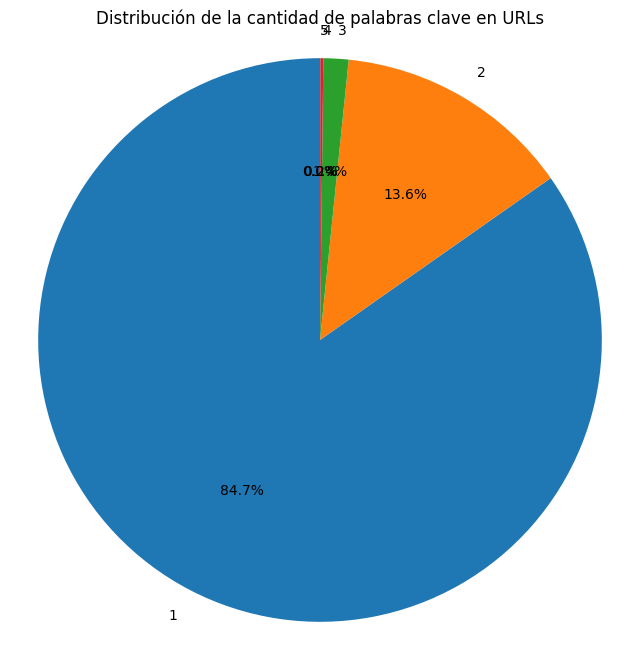

In [45]:
#Grafica de cantidad de registros con palabras clave

keyword_counts = df2['keyword_count'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(keyword_counts, labels=keyword_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de la cantidad de palabras clave en URLs')
plt.axis('equal')
plt.show()

In [46]:
#Conteo de registros con palabras clave

keyword_counts = df1.groupby('keyword_count').size()
keyword_counts

,0
keyword_count,
0,171930
1,13082
2,2105
3,222
4,27
5,2


In [47]:
suspicious_tlds = {".tk", ".ml", ".cf", ".ga", ".gq", ".xyz", ".top", ".win"}

# 🔹 Palabras clave comúnmente usadas en phishing
phishing_keywords = ["login", "secure", "bank", "verify", "account", "update",
                     "payment", "confirm", "password", "webscr", "signin", "ebayisapi", "token"]


In [48]:
#Extraccion de caracteristicas

#Función para extraer características de la URL
def extract_features(url):
    features = {}

    # Características básicas de la URL
    features['length'] = len(url)  # Longitud de la URL
    features['num_dots'] = url.count('.')  # Número de puntos
    features['num_hyphens'] = url.count('-')  # Número de guiones
    features['num_slashes'] = url.count('/')  # Número de barras
    features['num_digits'] = sum(c.isdigit() for c in url)  # Número de dígitos
    features['has_https'] = 1 if url.startswith('https') else 0  # Si usa HTTPS

    #Análisis del dominio y subdominio
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path

    features['num_subdomains'] = domain.count('.')  # Número de subdominios
    features['is_ip'] = 1 if domain.replace('.', '').isdigit() else 0  # Si usa IP

    phishing_keywords = ["login", "secure", "bank", "verify", "account", "update",
                     "payment", "confirm", "password", "webscr", "signin", "ebayisapi", "token"]

    #Palabras clave
    for keyword in phishing_keywords:
        features[f'keyword_{keyword}'] = 1 if keyword in url.lower() else 0

    return features


In [49]:
# Aplicar la función de extracción de características a todas las URLs
features = df1['url'].apply(extract_features).apply(pd.Series)


In [50]:
# Definir variables
X = features
y = df1['isMalicious']

In [51]:
# Conjunto de entrenamiento

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [52]:
# Crear y entrenar el modelo
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

In [53]:
# Evaluación del modelo
y_pred_rf = best_rf.predict(X_test)
print(f"Precisión: {accuracy_score(y_test, y_pred_rf):.2%}")

Precisión: 77.26%


In [57]:
urls_prueba = [
    "bugisshop.com/template/blog/images/alibaba/index.php?url_type=f",
    "montrealmirror.com/wp/2011/03/03/bye-bye-boustan",
    "imperiavkusov.ru/Easyweb%20TD%20Bank%20Trust%20Canada%20Online%20Banking/index.php",

]

In [55]:
def test_multiple_urls(url_list, model):
    results = []
    for url in url_list:
        features = extract_features(url)
        input_data = pd.DataFrame([features])
        prediction = model.predict(input_data)[0]
        probability = model.predict_proba(input_data)[0][1] * 100
        result = "PROBABLE PHISHING" if prediction == 1 else "URL SEGURO"
        results.append((url, result, probability))

    print("\nResultados de la prueba:")
    print("------------------------------------------------")
    for url, result, prob in results:
        print(f"URL: {url} --> {result} | Probabilidad: {prob:.2f}%\n")
        print("------------------------------------------------")


In [58]:
test_multiple_urls(urls_prueba, best_rf)



Resultados de la prueba:
------------------------------------------------
URL: bugisshop.com/template/blog/images/alibaba/index.php?url_type=f --> PROBABLE PHISHING | Probabilidad: 60.91%

------------------------------------------------
URL: montrealmirror.com/wp/2011/03/03/bye-bye-boustan --> URL SEGURO | Probabilidad: 19.76%

------------------------------------------------
URL: imperiavkusov.ru/Easyweb%20TD%20Bank%20Trust%20Canada%20Online%20Banking/index.php --> PROBABLE PHISHING | Probabilidad: 56.64%

------------------------------------------------
